# Homework 10: Regularized regression

This homework assignment is designed to give you an intuition as an interesting property of regularization in the context of ultra-high dimensional statistical problems.

You won't need to load in any data for this homework.

---
# Simulating & visualizing data (2 points)

We are going to be looking at what happens in the context where $p>n$. In order to have total control over our data, we will use simulations for this homework. First, we will need to load the `glmnet`, `tidyverse`, and `ggplot2` libraries for this assignment. 


In [9]:
#Load libraries (install if not done already)
# install.packages("glmnet")
library(glmnet)
library(tidyverse)
library(ggplot2)

# Let's also turn off warnings (we'll get them a lot in this assignment)
options(warn=-1)

Warning message:
“package ‘glmnet’ was built under R version 3.6.2”
Loading required package: Matrix

Loaded glmnet 4.1-1

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 3.6.2”
Warning message:
“package ‘tibble’ was built under R version 3.6.2”
Warning message:
“package ‘tidyr’ was built under R version 3.6.2”
Warning message:
“package ‘readr’ was built under R version 3.6.2”
Warning message:
“package ‘purrr’ was built under R version 3.6.2”
Warning message:
“package ‘dplyr’ was built under R version 3.6.2”
Warning message:
“package ‘forcats’ was built under R version 3.6.2”
── Conflicts ──────────────────────────────────────────────────────────────────────

We are going to generate a data set with complex structure and try to recover it using polynomial models. For simplicity sake, use the following code to produce a response variable, $y$ that has complex structure.

*Hint: Look up what a cosine function looks like if you need a reminder.*

In [10]:
# Generate data
set.seed(121)
sigma_noise = .5
x=seq(-9,9,by=.18)
n=length(x)
y = 0.1*x + cos(x) + cos(x/20)+rnorm(n,sd=sigma_noise)

(a) Break the data into a training set (n=50) and test set (n=51) using the `sample` function to randomly select subsets of x and y.  Make a separate data frame for the training and test data.

(**Note**: *Do not* just take the first 50 observations to be the training set and last 51 observations to be the test set.)

In [29]:
# WRITE YOUR CODE HERE
# Create the test and training indices
# Generate x_train, y_train, x_test, y_test fom the indices
# Create df_train, df_test
indices  = sample.int(n,size=50)
x_train = x[indices]
y_train = y[indices]
df_train = data.frame(x=x_train,y=y_train)
head(df_train)
test_indices = setdiff(1:n,sort(indices))
x_test = x[test_indices]
y_test = y[test_indices]
df_test = data.frame(x=x_test,y=y_test)
head(df_test)

,x,y
,<dbl>,<dbl>
1,7.74,1.3384153
2,8.82,1.1521831
3,-0.18,2.1916868
4,-9.00,-1.0383634
5,-2.16,0.2148265
6,0.18,0.9768865


,x,y
,<dbl>,<dbl>
1,-8.82,-0.74611573
2,-8.46,-0.54427456
3,-8.28,-0.68257115
4,-8.10,0.67322428
5,-7.56,-0.08663415
6,-7.38,1.10789561


(b) Plot the training data ($x$ \& $y$). Describe the relationship that you see in the training data.

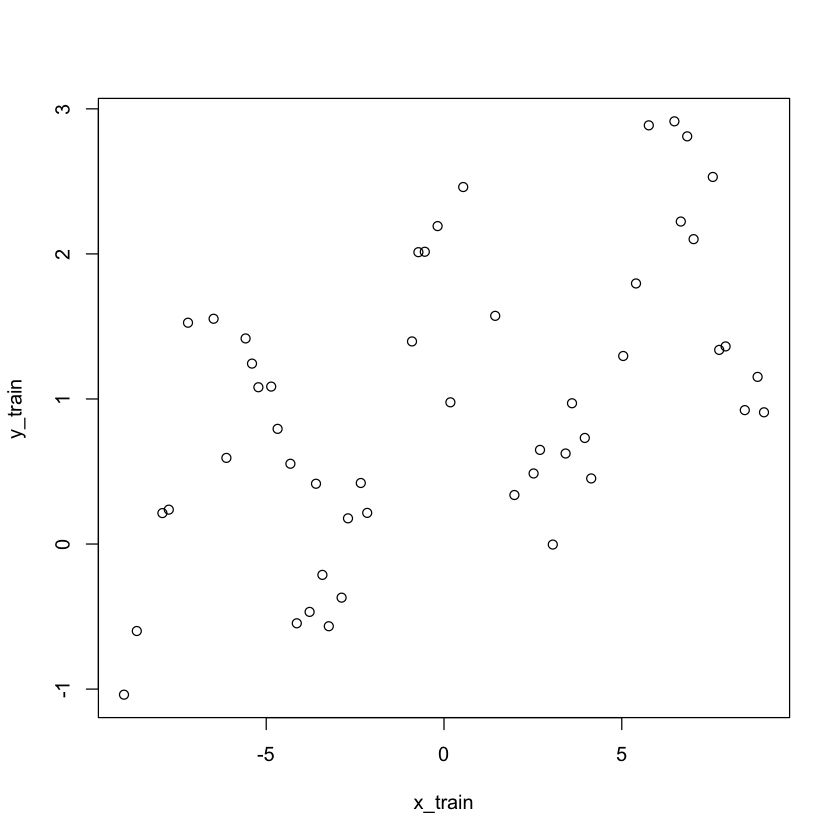

In [36]:
# WRITE YOUR CODE HERE
plot(x_train,y_train)

How would you describe the relationship between $x$ and $y$ based on this plot?

> There seems to be a linear relationship, but the relationship is noisy.


---
## Bias-variance tradeoff: polynomial regression (3 points)

Recall that in polynomial regression we increase model complexity by expanding $x$ out to the power $k$ (which we call degree).


$$Y = \hat{\beta}_0 + \sum_{j=1}^K \hat{\beta}_jX^j $$  

$$ = poly(x,k)$$

(a) Fit a 2nd degree polynomial regression model to the training data. Plot the results. 


*Hint: Use the* `help` *function to see how to use the* `stat_smooth()` *and* `poly()` *functions.*

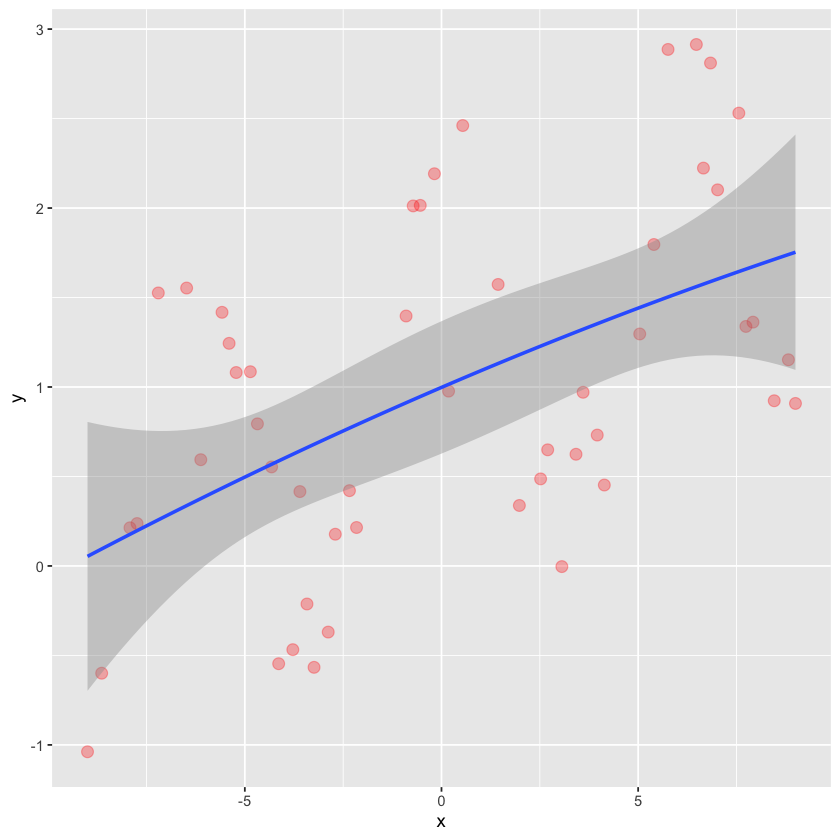

In [37]:
# WRITE YOUR CODE HERE
df_train %>% ggplot(aes(x=x, y=y)) + geom_point(color='red', alpha=0.3,size=3)+stat_smooth(method='lm', formula = y ~ poly(x, 2))

How well does this 2nd degree polynomial model qualitatively fit the data? Could it do better? 

> It captures the linear trend in the data pretty well. It could do better in terms of capturing the wavelike nature of y(we know this because of using cos function to generate y). 

(b) Fit a 12th degree polynomial to the data. Does this do qualitatively better or worse than the 2nd degree model?

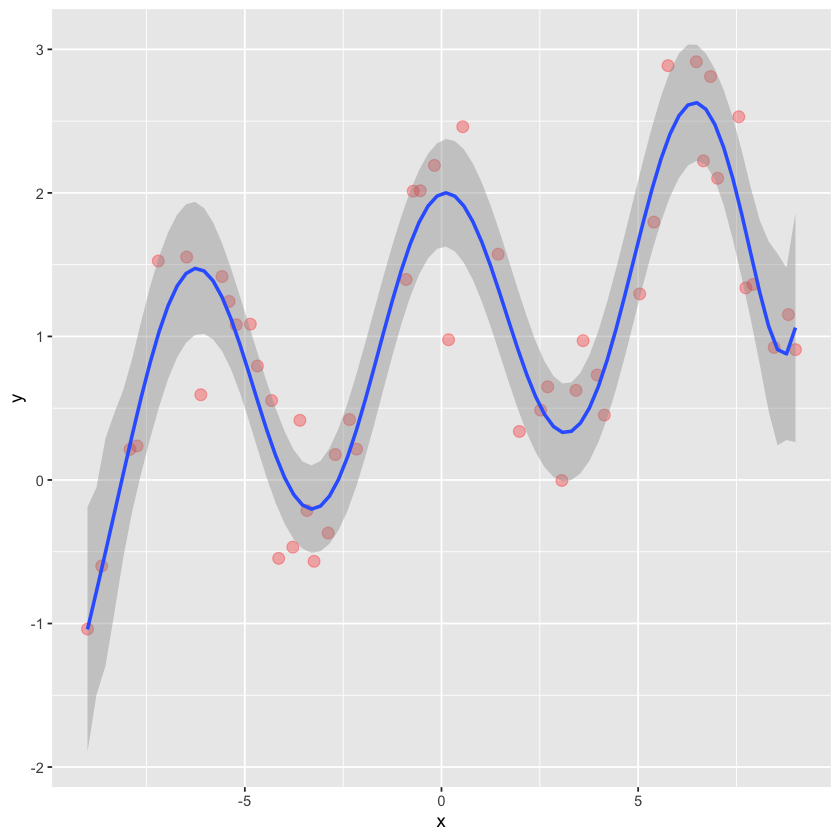

In [38]:
# WRITE YOUR CODE HERE
df_train %>% ggplot(aes(x=x, y=y)) + geom_point(color='red', alpha=0.3,size=3)+stat_smooth(method='lm', formula = y ~ poly(x, 12))

> This does substantially better than the first model. It captures the linear trend as well as wavelike nature of y.

(c) Modify the loop below to estimate the bias-variance tradeoff as model complexity (i.e., degree of the polynomial model, $k$) increases from 2 to 50. Use the training data to fit the model and test data to evaluate its predictive accuracy. Visualize your results by plotting the *median* squared error for the training data and test data as a function of polynomial degree. 


(**Note**: We are using median accuracies here because there are often 1 or 2 outlier values in the higher degree polynomial models that can throw off the accuracy estimates).

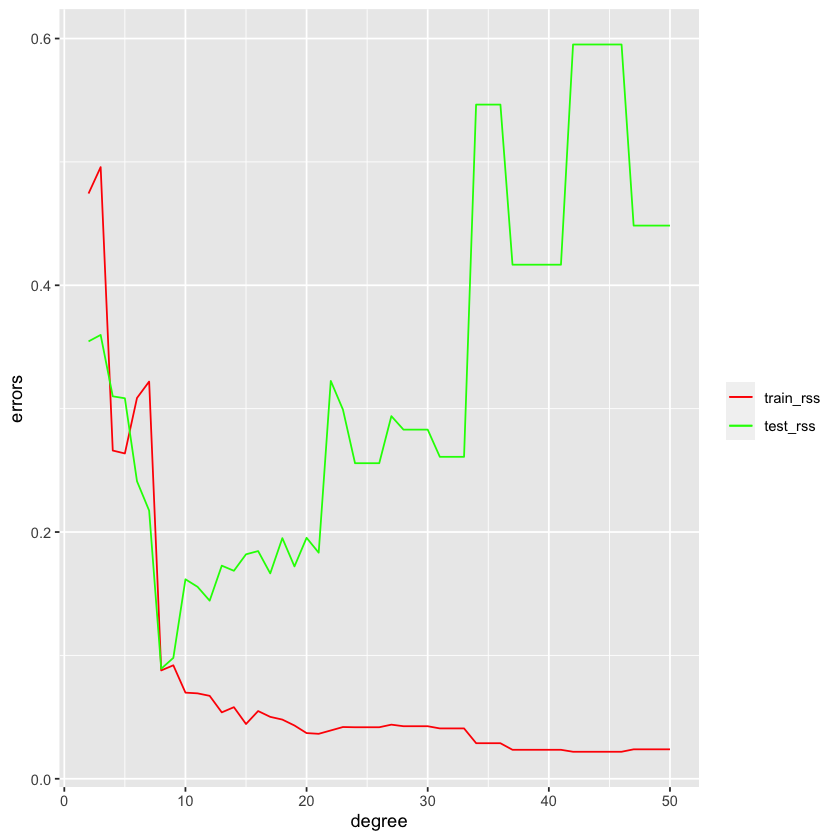

In [45]:
# Now do the variance-bias trade off analysis using regular regression
degree = seq(2,50)

# Need to setup your output vectors
train_rss = matrix(data=NA,nrow=length(degree),ncol=1)
test_rss = matrix(data=NA,nrow=length(degree),ncol=1)

for (k in degree) {
    # WRITE YOUR CODE HERE
    poly.glm = lm(y ~ poly(x, k,raw=TRUE),data=df_train)
    
    yhat_train = predict(poly.glm)
    yhat_test  = predict(poly.glm, newdata=df_test)

    # Because we get weird outlier predictions plot median sum square error
    # Also, k-1 because we are starting with k=2
    train_rss[k-1] = median((y_train - yhat_train)^2)
    test_rss[k-1] = median((y_test - yhat_test)^2)
}

# WRITE YOUR CODE HERE
# Plot your results here
errors = data.frame(train_rss=train_rss,test_rss=test_rss)
ggplot(errors, aes(x=degree,y=errors))   +
  geom_line(aes(y = train_rss, colour = "train_rss")) + 
  geom_line(aes(y = test_rss, colour="test_rss")) + 
  scale_colour_manual("", 
                      breaks = c("train_rss", "test_rss"),
                      values = c("red", "green"))

What do you see as $k$ increase?

> As the degree increases while the training error keeps decreasing, the test error starts to increase. This indicates that at higher degrees overfitting starts occuring and variance increases.

(d) Now copy the code above and let's see what happens when we go beyond $p=n$ (remember, in this case $k=p$). Test polynomial models up to $k=150$. Visualize your results by plotting the *median* squared error for the training data and test data as a function of polynomial degree. 

Use the `geom_vline()` function in `ggplot` to draw a vertical line where $k=n$ (here $n$ is the number of observations in the training set). This will make it clear where we cross the threshold for finding *unique* solutions in our data.



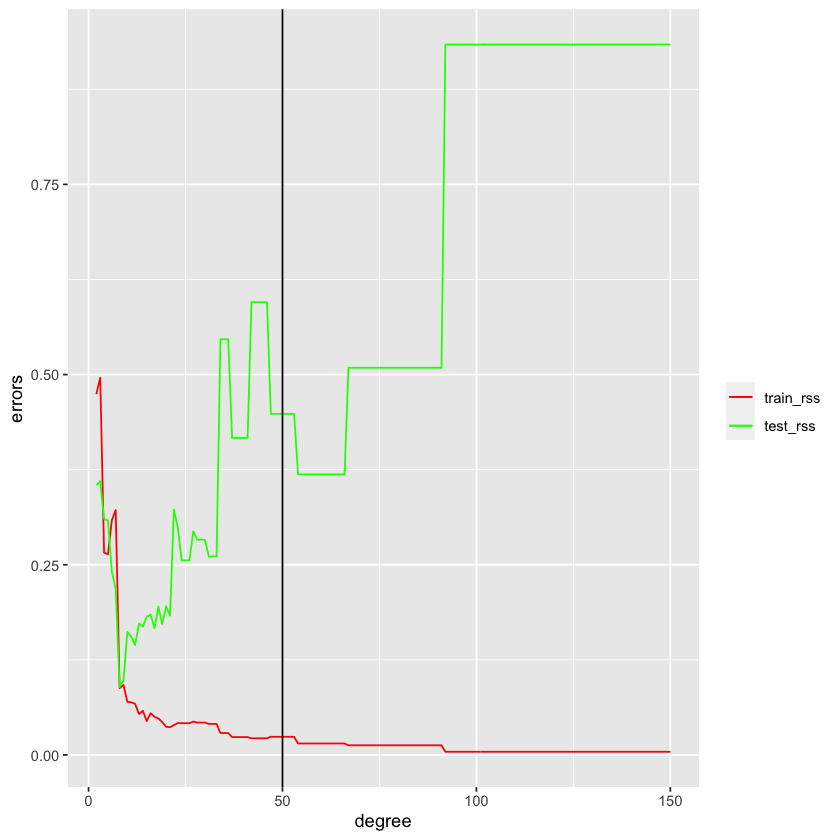

In [44]:
degree = seq(2,150)

# Need to setup your output vectors
train_rss = matrix(data=NA,nrow=length(degree),ncol=1)
test_rss = matrix(data=NA,nrow=length(degree),ncol=1)

for (k in degree) {
    # WRITE YOUR CODE HERE
    poly.glm = lm(y ~ poly(x, k,raw=TRUE),data=df_train)
    
    yhat_train = predict(poly.glm)
    yhat_test  = predict(poly.glm, newdata=df_test)

    # Because we get weird outlier predictions plot median sum square error
    # Also, k-1 because we are starting with k=2
    train_rss[k-1] = median((y_train - yhat_train)^2)
    test_rss[k-1] = median((y_test - yhat_test)^2)
}

# WRITE YOUR CODE HERE
# Plot your results here

errors = data.frame(train_rss=train_rss,test_rss=test_rss)
ggplot(errors, aes(x=degree,y=errors))   +
  geom_line(aes(y = train_rss, colour = "train_rss")) + 
  geom_line(aes(y = test_rss, colour="test_rss")) + 
  scale_colour_manual("", 
                      breaks = c("train_rss", "test_rss"),
                      values = c("red", "green")) + geom_vline(xintercept = length(df_train$x))

What do you see as $k$ gets larger than $n$?

> The training error stabilizes and testing error fluctuates by a little but also seems to stabilize. Adding more degrees doesn't improve the model but instead completely overfits to the training data to achieve an error of 0 - the model has very high variance. 

---
## Applying regularization to the model fits (2 points)

Repeat the previous bias-variance tradeoff test, going up to $k=150$, but now use ridge regression with a sparsity parameter of $\lambda=0.00005$. Plot your results the same way as last time. 

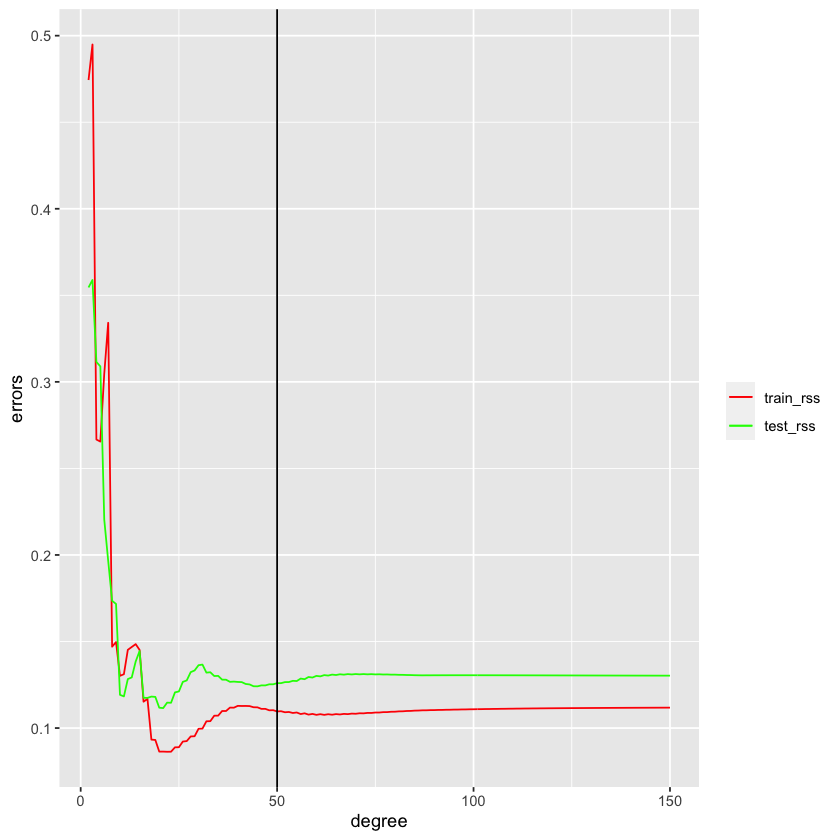

In [41]:
# Now do the variance-bias trade off analysis using ridge regression
lambda=0.00005
degree = seq(2,150)

rm(train_rss, test_rss)
train_rss = matrix(data=NA,nrow=length(degree),ncol=1)
test_rss = matrix(data=NA,nrow=length(degree),ncol=1)


for (k in degree) {
    # WRITE YOUR CODE HERE
    #ridge.glm = INSERT RIDGE MODEL WITH POLYNOMIAL TERMS & LAMBDA
    ridge.glm = glmnet(poly(x_train, k, raw=TRUE), y_train, alpha=0, lambda=lambda)

    yhat_train = predict(ridge.glm, newx=poly(x_train, k, raw=TRUE))
    yhat_test  = predict(ridge.glm, newx=poly(x_test, k, raw=TRUE))

   # Because we get weird outlier predictions plot median sum square error
    train_rss[k-1] = median((y_train - yhat_train)^2)
    test_rss[k-1] = median((y_test - yhat_test)^2)
}

# WRITE YOUR CODE HERE
# Plot your results here
errors = data.frame(train_rss=train_rss,test_rss=test_rss)
ggplot(errors, aes(x=degree,y=errors))   +
  geom_line(aes(y = train_rss, colour = "train_rss")) + 
  geom_line(aes(y = test_rss, colour="test_rss")) + 
  scale_colour_manual("", 
                      breaks = c("train_rss", "test_rss"),
                      values = c("red", "green")) + geom_vline(xintercept = length(df_train$x))

What happens now when $k$ gets larger than $n$?

> Now despite having a high degree polynomial, the training error doesn't go down to 0. This means overfitting is prevented. We also see a drop in testing error at high order polynomials. 

## Reflection (2 points)

The simulations above should have shown that, when applying a regularization (i.e., a sparsity constraint), the behavior of the bias-variance tradeoff changes. Explain why this happens.

> Overfitting is defined by high variance. High variance means each point contributes significantly to the output and hence all input points are assigned a high coefficient. Ridge regression by forcing coefficients to be small reduces each point's contribution and hence reduces some variance to get some increase in bias. Increased bias leads to a curve which doesn't cover all input points and hence the training error doesn't go to 0, even when the degree of the polynomial is very high.  

--- 
## Bonus (1 extra credit point)
Recall that the $p=n$ threshold defines the limit for finding a *unique* solution to $Y=F(X)$ (i.e., there is only one combination of regression coefficients that is *best* at explaining variance in $Y$). With this in mind, what is regularization doing that works around this upper limit?

> In polynomial regression, the closed form of coefficients($\beta$) is $\beta = (X^TX)^{-1}XY$ where X and Y are input and output respectively(this equation is rearranged form of y=f(x)). The inverse of $(X^TX)$ is required to find a unique set of values for $\beta$. When p=n, $(X^TX)$ becomes un-invertible, and so no unique solution is possible. Ridge regression adds a regularization term to this equation $\beta = (X^TX + \lambda I)^{-1}XY$. $(X^TX + \lambda I)$ is invertible at p>n and again a unique solution becomes possible. 

---

**DUE:** 5pm EST, April 25, 2021

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> Fiona Horner, Aden Halpern
